In [1]:
import numpy as np 
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from jax import numpy as jnp
import jax 

In [2]:
theta = 1
R = 1 

o1 = np.array([-np.cos(theta), 0, 0]) 
o2 = np.array([np.cos(theta), 0, 0])

x, y = np.meshgrid(np.linspace(-2*R, 2*R, 100), np.linspace(-2*R, 2*R, 100))

h1 = np.zeros_like(x) 
h2 = np.zeros_like(x) 
m1 = ((x-o1[0])**2 + y**2 <= R**2)
m2 = ((x-o2[0])**2 + y**2 <= R**2)

h1[m1] = np.sqrt(R**2 - ((x[m1]-o1[0])**2 + y[m1]**2))
h2[m2] = np.sqrt(R**2 - ((x[m2]-o2[0])**2 + y[m2]**2))
h = np.maximum(h1, h2)



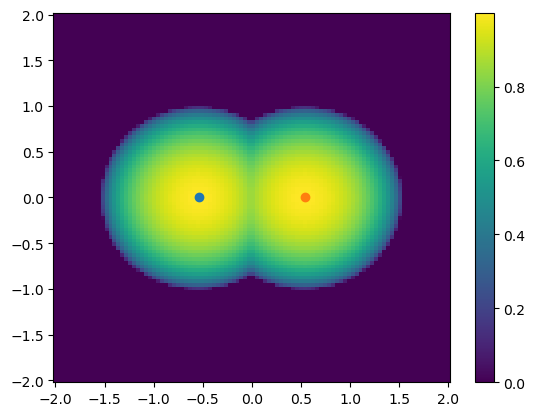

In [3]:
plt.pcolor(x, y, h)
plt.plot(o1[0], o1[1], 'o')
plt.plot(o2[0], o2[1], 'o')
plt.colorbar() 
plt.show() 

In [43]:
fig = go.Figure(data=[go.Surface(x=x, y=y, z=h)])

fig.update_layout(
    title='Cleavage Surface of Two Spheres',
    scene = dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z', 
        aspectratio=dict(x=1, y=1, z=0.25)
    ),
    width=800,
    height=800
)

fig.show()

In [20]:
# define dimensionless parameters 
k = 0.1 
Ta = 0.1
l = 0.05 # w/(pi*R_0) 
phi_dot = 0.1  


def F(theta): 
    return (1 + 3/2*jnp.cos(theta) - 1/2*(jnp.cos(theta))**3)**(1/3)


def Delta(theta, phi): 
    return jnp.cos(theta) - F(theta)*jnp.sin(phi)

def D(theta, phi): 
    return F(theta)*jnp.cos(phi) 

def R_tilde(theta, phi): 
    return (D(theta, phi)**2 + Delta(theta, phi)**2)/(2*Delta(theta, phi))

def psi(theta, phi): 
    return jnp.arcsin(D(theta, phi)/R_tilde(theta, phi))

def zeta(theta, phi): 
    return psi(theta, phi)*R_tilde(theta, phi)/F(theta)/np.pi 

def G(theta, phi): 
    term1 = (1+jnp.cos(theta))/F(theta)**2
    term2 = k*zeta(theta, phi) 
    return term1 + term2 

def A(theta, phi): 
    return Ta/2*np.pi**2*(1+jnp.cos(theta))**2 + l/zeta(theta, phi) 

dzeta_dtheta = jax.grad(zeta, argnums=0)
dzeta_dphi = jax.grad(zeta, argnums=1)
dG_dtheta = jax.grad(G, argnums=0)
dG_dphi = jax.grad(G, argnums=1)

def dtheta_dt(theta, phi): 
    a = dzeta_dtheta(theta, phi)**2*A(theta, phi)
    b = dG_dtheta(theta, phi) + 2*phi_dot*dzeta_dphi(theta, phi)*dzeta_dtheta(theta, phi)*A(theta, phi)
    c = A(theta, phi)*phi_dot**2*(dzeta_dphi(theta, phi)**2) + phi_dot*(dG_dphi(theta, phi) - k/np.pi)
    
    return (-(b**2- 4*a*c)**(1/2) - b)/(2*a)
    # return (b**2- 4*a*c)





In [52]:
theta = np.pi/2 
phi = 0.1

print(F(theta))
print(psi(theta, phi)) 
print(zeta(theta, phi))
print(G(theta, phi))
print(A(theta, phi))
print(dtheta_dt(theta, phi))

1.0
-0.2000001
0.318841
1.1275363
0.6502981
-15.242841


In [59]:
import diffrax 

# define dimensionless parameters 
k = 0.4
Ta = 0.1
l = 0.05 # w/(pi*R_0) 
phi_dot = 0.2

# Define your ODE (same harmonic oscillator)
def rhs(t, theta, args):
    return dtheta_dt(theta, phi_dot*t)

# Setup the problem
t0 = 0.0
t1 = (np.pi/2/phi_dot)*0.99
dt0 = 0.01
y0 = np.pi/2 

# Create the solver
term = diffrax.ODETerm(rhs)
solver = diffrax.Dopri5()  # This is a good general-purpose solver
saveat = diffrax.SaveAt(ts=jnp.linspace(t0, t1, 100))

# Solve
solution = diffrax.diffeqsolve(
    term,
    solver,
    t0=t0,
    t1=t1,
    dt0=dt0,
    y0=y0,
    args=None, 
    saveat=saveat
)

# Get solution
ts = solution.ts  # time points
ys = solution.ys  # solution at each time point



In [57]:
print(ys)

[1.5707964e+00 1.1658957e+00 1.1519456e+00 1.1381661e+00 1.1245462e+00
 1.1110775e+00 1.0977492e+00 1.0845525e+00 1.0714791e+00 1.0585234e+00
 1.0456768e+00 1.0329332e+00 1.0202866e+00 1.0077310e+00 9.9526024e-01
 9.8286855e-01 9.7055513e-01 9.5830989e-01 9.4612992e-01 9.3401098e-01
 9.2194825e-01 9.0993690e-01 8.9797479e-01 8.8605523e-01 8.7417626e-01
 8.6233234e-01 8.5051996e-01 8.3873528e-01 8.2697415e-01 8.1523299e-01
 8.0350620e-01 7.9179335e-01 7.8008693e-01 7.6838356e-01 7.5668031e-01
 7.4497145e-01 7.3325378e-01 7.2152072e-01 7.0976919e-01 6.9799405e-01
 6.8618912e-01 6.7435479e-01 6.6248095e-01 6.5054917e-01 6.3842827e-01
 6.2893921e-01 6.1684668e-01 6.0468853e-01 5.9245706e-01 5.8013695e-01
 5.6772149e-01 5.5519992e-01 5.4256260e-01 5.2979761e-01 5.1689315e-01
 5.0383455e-01 4.9060676e-01 4.7719234e-01 4.6357214e-01 4.4972420e-01
 4.3562469e-01 4.2124239e-01 4.0654689e-01 3.9149901e-01 3.7605369e-01
 3.6015591e-01 3.4374058e-01 3.2672605e-01 3.0901060e-01 2.9046261e-01
 2.709

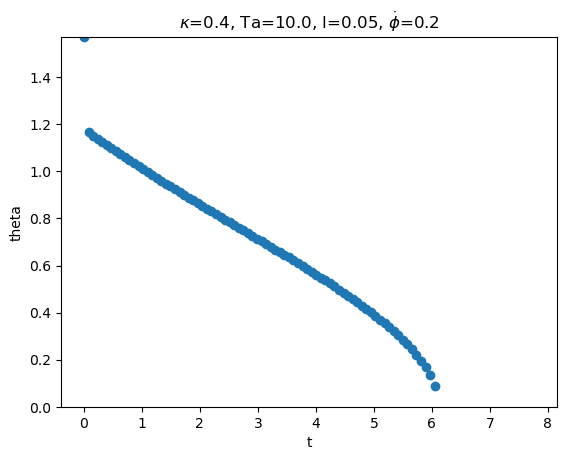

In [68]:
plt.plot(ts, ys, 'o')
plt.xlabel('t')
plt.ylabel('theta')
plt.ylim([0, np.pi/2])
plt.title(rf'${{\kappa}}$={k}, Ta={1/Ta}, l={l}, $\dot{{\phi}}$={phi_dot}')
plt.show()


In [2]:
from diffrax import diffeqsolve, ODETerm, Dopri5
import jax.numpy as jnp

def f(t, y, args):
    return -y

term = ODETerm(f)
solver = Dopri5()
y0 = jnp.array([2., 3.])
solution = diffeqsolve(term, solver, t0=0, t1=1, dt0=0.1, y0=y0)